<a href="https://colab.research.google.com/github/LawalIbraheem19/Machine-Learning/blob/main/Core_Learning_Algorithms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TensorFlow Core Learning Algorithms

In this notebook, we will walk through 4 fundamental machine learning algorithms.
The Algorithms which we will focus on include:


*   Linear Regression
*   Classification
*   Clustering
*   Hidden Markov Models




# Linear Regression

Linear regression is one of the most basic forms of machine learning and is used to predict numeric values.

In this tutorial we will use a linear model to predict the survival rate of passangers from the titanic dataset.

# How it works

Linear regression follows a very simple concept. If data points are related linearly, we can generate a line of best fit for these points and use it to predict future values.

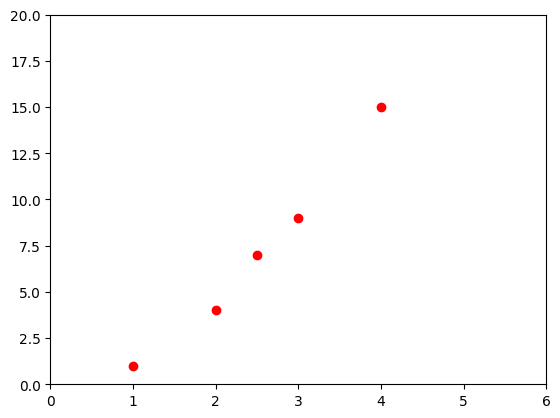

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

x = [1, 2, 2.5, 3, 4]
y = [1, 4, 7, 9, 15]

plt.plot(x, y, 'ro')
plt.axis([0,6,0,20])
plt.show()

We can see that this data has a linear coorespondence. When the x value increases, so does the y. Because of this relation we can create a line of best fit for this dataset. In this example our line will only use one input variable, as we are working with two dimensions. In larger datasets with more features our line will have more features and inputs.

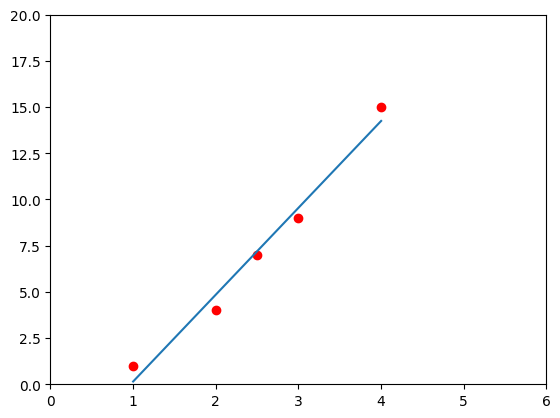

In [ ]:
plt.plot(x, y, 'ro')
plt.axis([0,6,0,20])
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
plt.show()

# Setup and Imports

In [ ]:
!pip install -U scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 26.9 MB/s eta 0:00:00


In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib

import tensorflow.compat.v2.feature_column as fc

import tensorflow as tf


# Data

The dataset we will be focusing on here is the titanic dataset. It has tons of information about each passanger on the ship. Our first step is always to understand the data and explore it. So, let's do that!

*Below we will load a dataset and learn how we can explore it using some built-in tools. *

In [ ]:
# Load dataset.
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv') # training data
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv') # testing data
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')

In [ ]:
dftrain

In [ ]:
dftrain.describe()

In [ ]:
dftrain.shape

# Visual Exploration

In [ ]:
dftrain.age.hist(bins=20)

In [ ]:
dftrain.sex.value_counts().plot(kind='barh')

In [ ]:
dftrain['class'].value_counts().plot(kind='barh')

In [ ]:
pd.concat([dftrain, y_train], axis=1).groupby('sex')['survived'].mean().plot(kind='barh').set_xlabel("%survived")

After analyzing this information, we should notice the following:

* Most passengers are in their 20's or 30's
* Most passengers are male
* Most passengers are in "Third" class
* Females have a much higher chance of survival

$y = mx + b$

# Training vs Testing Data

The training data is what we feed to the model so that it can develop and learn. It is usually a much larger size than the testing data.

The testing data is what we use to evaulate the model and see how well it is performing. We must use a seperate set of data that the model has not been trained on to evaluate it.

# Feature Columns

Our categorical data is anything that is not numeric! For example, the sex column does not use numbers, it uses the words "male" and "female".

Before we continue and create/train a model we must convet our categorical data into numeric data. We can do this by encoding each category with an integer (ex. male = 1, female = 2).

In [ ]:
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck',
                       'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
    vocabulary = dftrain[feature_name].unique() #gets a list of unique feature in the given feature
    feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
    feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

print(feature_columns)

# The Training Process

To train our model, we employ a technique called batch processing, where data is fed into the model in small increments known as batches. Each batch contains 32 entries from our dataset. Rather than presenting the entire dataset at once, we repeatedly feed these batches into the model over multiple passes, known as epochs.

An **epoch** represents a single iteration through the entire dataset. By specifying the number of epochs, we determine how many times the model will encounter the entire dataset during training. The goal of using multiple epochs is to allow the model to progressively learn from the data, refining its estimations with each pass.

For instance, if we set the number of epochs to 10, the model will iterate through the dataset 10 times in total, gradually improving its understanding of the data.

To facilitate this batch processing and multiple epochs, we need to create an input function. This function specifies how the dataset will be converted into batches at each epoch, ensuring that the model receives the data in the desired format for training.

# Input Function

The TensorFlow model we are going to use requires that the data we pass it comes in as a tf.data.Dataset object. This means we must create a input function that can convert our current pandas dataframe into that object.

Below you'll see a seemingly complicated input function, this is straight from the TensorFlow documentation (https://www.tensorflow.org/tutorials/estimator/linear). I've commented as much as I can to make it understandble, but you may want to refer to the documentation for a detailed explination of each method.

In [ ]:
def make_input_fn(data_df, label_df, num_of_epochs=10, shuffle=True, batch_size=32):
    def input_function(): #inner function, this will be returned
        ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))    # create tf.data.Dataset object with data and its label
        if shuffle: #randomize order of data
            ds = ds.shuffle(1000)
        ds = ds.batch(batch_size).repeat(num_of_epochs)  # split dataset into batches of 32 and repeat process for number of epochs
        return ds #return a batch of the dataset
    return input_function #return a function object for use

train_input_fn = make_input_fn(dftrain, y_train)  # here we will call the input_function that was returned to us to get a dataset object we can feed to the model
eval_input_fn = make_input_fn(dfeval, y_eval, num_of_epochs=1, shuffle=False)

## Creating the Model

In this tutorial we are going to use a linear estimator to utilize the linear regression algorithm.

In [ ]:
linear_regr = tf.estimator.LinearClassifier(feature_columns=feature_columns)
# We create a linear estimtor by passing the feature columns we created earlier

# Training the Model

In [ ]:
linear_regr.train(train_input_fn)   #train
result = linear_regr.evaluate(eval_input_fn)    # get model metrics/stats by testing on tetsing data

clear_output()  #clears consoke output
print(result['accuracy'])   #the result variable is simply a dict of stats about our model

In [ ]:
print(result)

We can use the ```.predict()``` method to get survival probabilities from the model. This method will return a list of dicts that store a predicition for each of the entries in our testing data set. Below we've used some pandas magic to plot a nice graph of the predictions.

In [ ]:
pred_dicts = list(linear_regr.predict(eval_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

probs.plot(kind='hist', bins=20, title='predicted probabilities')

# Classification


Now that we've discussed linear regression, let's delve into classification. Unlike regression, where the aim is to predict a numeric value, classification involves sorting data points into different classes or categories based on their features. In this example, we'll employ a TensorFlow estimator to classify flowers.

In classification tasks, the goal is often to assign each data point to one of several predefined classes or labels. In the context of flower classification, we might aim to categorize different types of flowers based on various features such as petal length, petal width, sepal length, and sepal width.

With TensorFlow's estimator framework, we can efficiently build and train classification models. This involves tasks such as defining feature columns, selecting an appropriate model architecture (such as a neural network), configuring training parameters, and then training the model on our flower data to predict the flower species.

Shall we proceed with a detailed discussion on how to implement this flower classification task using TensorFlow's estimator API? We can cover topics like defining feature columns, choosing a suitable model architecture, and setting up the training and evaluation process.

# Control and Setup

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import pandas as pd

# Datasets

This specific dataset seperates flowers into 3 different classes of species.

* Setosa
* Versicolor
* Virginica

The information about each flower is the following.

* sepal length
* sepal width
* petal length
* petal width

In [ ]:
FLOWER_COLUMN_NAMES = ['SepalLength', 'SepalWidth', 'PetalLength', 'PetalWidth', 'Species']
SPECIES = ['Setosa', 'Versicolor', 'Virginica']
# Lets define some constants to help us later on

In [ ]:
train_path = tf.keras.utils.get_file(
    "iris_training.csv", "https://storage.googleapis.com/download.tensorflow.org/data/iris_training.csv")
test_path = tf.keras.utils.get_file(
    "iris_test.csv", "https://storage.googleapis.com/download.tensorflow.org/data/iris_test.csv")

train = pd.read_csv(train_path, names=FLOWER_COLUMN_NAMES, header=0)
test = pd.read_csv(test_path, names=FLOWER_COLUMN_NAMES, header=0)
# Here we use keras (a module inside of TensorFlow) to grab our datasets and read them into a pandas dataframe

573/573 [==============================] - 0s 0us/step


Lets have a look at the dataset

In [ ]:
train.head()

,SepalLength,SepalWidth,PetalLength,PetalWidth,Species
0,6.4,2.8,5.6,2.2,2
1,5.0,2.3,3.3,1.0,1
2,4.9,2.5,4.5,1.7,2
3,4.9,3.1,1.5,0.1,0
4,5.7,3.8,1.7,0.3,0


Now, we can pop the species column

In [ ]:
train_y = train.pop('Species')
test_y = test.pop('Species')


train_y.head()

0    2
1    1
2    2
3    0
4    0
Name: Species, dtype: int64

In [ ]:
train.shape

(120, 4)

# Input Function

In [ ]:
def input_fn(features, labels, training=True, batch_size=256):
    #convert the inputs to a dataset
    dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))

    #shuffle dataset in training and repeat
    if training:
        dataset = dataset.shuffle(1000).repeat()

    return dataset.batch(batch_size)

# Feature Columns

In [ ]:
#Feature columns describes the input column
my_feature_column = []
for key in train.keys():
    my_feature_column.append(tf.feature_column.numeric_column(key=key))

print(my_feature_column)

[NumericColumn(key='SepalLength', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='SepalWidth', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='PetalLength', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='PetalWidth', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]


# Building The Model

 For classification tasks there are variety of different estimators/models that we can pick from. Some options are listed below.

* ```DNNClassifier```(Deep Neural Network)
* ```LinearClassifier```

We can choose either model but the DNN seems to be the best choice. This is because we may not be able to find a linear coorespondence in our data.

So let's build a model!

In [ ]:
# Build a DNN with 2 hidden layers with 30 and 10 hidden nodes each.
classifier = tf.estimator.DNNClassifier(
    feature_columns= my_feature_column,
    # Two hidden layers of 30 and 10 nodes respectively.
    hidden_units = [30,10],
    # The model must choose between 3 classes.
    n_classes=3)

Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.


What we've just done is created a deep neural network that has two hidden layers. These layers have 30 and 10 neurons respectively. This is the number of neurons the TensorFlow official tutorial uses so we'll stick with it. However, it is worth mentioning that the number of hidden neurons is an arbitrary number and many experiments and tests are usually done to determine the best choice for these values. Try playing around with the number of hidden neurons and see if your results change.

# Training

In [ ]:
classifier.train(
    input_fn= lambda:  input_fn(train, train_y, training=True),
    steps=5000
                )
#we include a  lambda to avoid creating an inner function"

The steps argument simply tells the classifier to run for 5000 steps. Try modifiying this and seeing if your results change. Keep in mind that more is not always better.

# Evaluation

Lets see how this trained model performs on the dataset


In [ ]:
eval_result = classifier.evaluate(
    input_fn= lambda:  input_fn(test, test_y, training=False)
)

print('\nThe accuracy of the model on the test set: {accuracy:0.3f}\n'.format(**eval_result))

Our model did quite well on the test set

In [ ]:
def input_fn(features, batch_size=256):
    #Convert the inputs to a Dataset withour a labels.
    return tf.data.Dataset.from_tensor_slices(dict(features)).batch(batch_size)

features = ['SepalLength', 'SepalWidth', 'PetalLength', 'PetalWidth']
predict = {}

print("Please type numeric values as prompted.")

for feature in features:
    valid = True
    while valid:
        val = input(feature + ": ")
        if not val.isdigit(): valid= False
    predict[feature] = [float(val)]

predictions = classifier.predict(input_fn=lambda: input_fn(predict))

for pred_dict in predictions:
    class_id = pred_dict['class_ids'][0]
    probability = pred_dict['probabilities'][class_id]

    print('Prediction is "{}" ({:.1f})'.format(
        SPECIES[class_id], 100 * probability))

Please type numeric values as prompted.
SepalLength: 5.1
SepalWidth: 3.3
PetalLength: 1.7
PetalWidth: 0.5


Exception ignored in: <generator object Estimator.predict at 0x7a3f552ee6c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 618, in predict
  File "/usr/lib/python3.10/contextlib.py", line 153, in __exit__
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 4579, in get_controller
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/context.py", line 287, in pop
IndexError: pop from empty list


Prediction is "Setosa" (79.9)


**Clustering**



Now that we've discussed regression and classification, let's explore clustering data.

Clustering is a fundamental machine learning technique used to group data points based on similarities in their properties or features. The goal is to partition the data into clusters, where data points within the same cluster are more alike to each other than to those in other clusters.

One of the most popular clustering algorithms is K-Means. Here's a simplified version of its basic steps:

1. **Initialization**:
   - Randomly select K points from the dataset as initial centroids.

2. **Assignment**:
   - Assign each data point to the nearest centroid based on distance, typically using Euclidean distance.

3. **Update Centroids**:
   - Compute the mean of all data points assigned to each centroid and update the centroid's position.

4. **Reassignment**:
   - Reassign each data point to the closest centroid.

5. **Iteration**:
   - Repeat steps 3 and 4 until convergence, where no data point changes its assigned centroid.

While TensorFlow does offer K-Means clustering, there may be limitations or issues with its implementation. In such cases, one might need to resort to other libraries or implement K-Means from scratch.

Understanding the basics of clustering and algorithms like K-Means is crucial for data analysis and exploration tasks. It allows for the discovery of patterns and structures within the data, aiding in insights and decision-making processes.

If you're interested in delving deeper into clustering, there are various other algorithms worth exploring, such as hierarchical clustering, DBSCAN, and Gaussian mixture models.

Feel free to ask if you have any specific questions or if you'd like to explore other aspects of clustering further!

(https://towardsdatascience.com/the-5-clustering-algorithms-data-scientists-need-to-know-a36d136ef68)

**Hidden Markov Models**

The Hidden Markov Model is a finite set of states, each of which is associated with a (generally multidimensional) probability distribution []. Transitions among the states are governed by a set of probabilities called transition probabilities. In a particular state an outcome or observation can be generated, according to the associated probability distribution. It is only the outcome, not the state visible to an external observer and therefore states are ``hidden'' to the outside; hence the name Hidden Markov Model

Data

Let's start by discussing the type of data we use when we work with a hidden markov model.

In the previous sections we worked with large datasets of 100's of different entries. For a markov model we are only interested in probability distributions that have to do with states.

We can find these probabilities from large datasets or may already have these values. We'll run through an example in a second that should clear some things up, but let's discuss the components of a markov model.

States: In each markov model we have a finite set of states. These states could be something like "warm" and "cold" or "high" and "low" or even "red", "green" and "blue". These states are "hidden" within the model, which means we do not direcly observe them.

Observations: Each state has a particular outcome or observation associated with it based on a probability distribution. An example of this is the following: On a hot day Tim has a 80% chance of being happy and a 20% chance of being sad.

Transitions: Each state will have a probability defining the likelyhood of transitioning to a different state. An example is the following: a cold day has a 30% chance of being followed by a hot day and a 70% chance of being follwed by another cold day.

To create a hidden markov model we need.

States
Observation Distribution
Transition Distribution
For our purpose we will assume we already have this information available as we attempt to predict the weather on a given day.

**Imports and Setup**

In [7]:
import tensorflow_probability as tfp
import tensorflow as tf

**Weather Model**

This model example was taken directly from the TensorFlow documentation (https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/HiddenMarkovModel).

We will model a simple weather system and try to predict the temperature on each day given the following information.

Cold days are encoded by a 0 and hot days are encoded by a
1. The first day in our sequence has an 80% chance of being cold.
2. A cold day has a 30% chance of being followed by a hot day.
3. A hot day has a 20% chance of being followed by a cold day.
On each day the temperature is normally distributed with mean and standard deviation 0 and 5 on a cold day and mean and standard deviation 15 and 10 on a hot day.


If you're unfamiliar with standard deviation it can be put simply as the range of expected values.

In this example, on a hot day the average temperature is 15 and ranges from 5 to 25.

To model this in TensorFlow we will do the following.

In [4]:
tfd = tfp.distributions
initial_distribution = tfd.Categorical(probs= [0.2, 0.8]) #refer to point 2 above
transition_distribution = tfd.Categorical(probs= [[0.5, 0.5],
                                                [0.2, 0.8]]) #refer to point 3 and 4 above

observation_distribution = tfd.Normal(loc = [0. , 15.], scale = [5., 10.]) #refer to point 5 above

# the loc argument represents the mean and the scale is the standard devitation

We have now created distribution variables to model our system and it's time to create the hidden markov model.







In [5]:
model = tfd.HiddenMarkovModel(
                            initial_distribution = initial_distribution,
                            transition_distribution = transition_distribution,
                            observation_distribution = observation_distribution,
                            num_steps=7)

The number of steps represents the number of days that we would like to predict information for. In this case we've chosen 7, an entire week.

To get the expected temperatures on each day we can do the following.

In [8]:
mean = model.mean()
# due to the way TensorFlow works on a lower level we need to evaluate part of the graph
# from within a session to see the value of this tensor

# in the new version of tensorflow we need to use tf.compat.v1.Session() rather than just tf.Session()

with tf.compat.v1.Session() as sess:
  print(mean.numpy())

[11.999999 11.1      10.830001 10.748999 10.724699 10.71741  10.715222]


**Conclusion**

So that's it for the core learning algorithms in TensorFlow. Hopefully you've learned about a few interesting tools that are easy to use! To practice I'd encourage you to try out some of these algorithms on different datasets.

**Sources**

Chen, James. “Line Of Best Fit.” Investopedia, Investopedia, 29 Jan. 2020, www.investopedia.com/terms/l/line-of-best-fit.asp.
“Tf.feature_column.categorical_column_with_vocabulary_list.” TensorFlow, www.tensorflow.org/api_docs/python/tf/feature_column/categorical_column_with_vocabulary_list?version=stable.
“Build a Linear Model with Estimators  :   TensorFlow Core.” TensorFlow, www.tensorflow.org/tutorials/estimator/linear.
Staff, EasyBib. “The Free Automatic Bibliography Composer.” EasyBib, Chegg, 1 Jan. 2020, www.easybib.com/project/style/mla8?id=1582473656_5e52a1b8c84d52.80301186.
Seif, George. “The 5 Clustering Algorithms Data Scientists Need to Know.” Medium, Towards Data Science, 14 Sept. 2019, https://towardsdatascience.com/the-5-clustering-algorithms-data-scientists-need-to-know-a36d136ef68.
Definition of Hidden Markov Model, http://jedlik.phy.bme.hu/~gerjanos/HMM/node4.html.
“Tfp.distributions.HiddenMarkovModel  :   TensorFlow Probability.” TensorFlow, www.tensorflow.org/probability/api_docs/python/tfp/distributions/HiddenMarkovModel.